# Metodología

## Recolección de datos

Importamos librerías necesarias durante le desarrollo del algoritmo.

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import math as mt
import random as rd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

Accedemos a la carpeta de drive donde se encuentra la base de datos.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Cargamos la base de datos Drugs ABCXY, dentro de la variable 'DB'.

In [ ]:
DB = pd.read_csv('/content/drive/MyDrive/ML_TSIV/Decision_Tree/Drugs ABCXY.csv')

Dejamos estática la base de datos sin modificar procesos posteriores.

In [ ]:
DB_STAY = DB

Damos un primer vistazo a la base de datos, mostrando los datos organizados en una tabla.

In [ ]:
DB.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


Función para transformar cada atributo cualitativo dentro de la base de datos a datos numéricos.

In [ ]:
def Cualit2Num(DBCN):
  Titles = list(DBCN.columns)

  Titles_str = []
  for title in Titles:
    if type(DBCN[title][0]) == str:
      Titles_str.append(title)

  for title in Titles_str:
    types = pd.unique(DBCN[title])
    i = 0
    for data in types:
      data_loc = np.where(DBCN[title] == data)[0]
      for pos in data_loc:
        DBCN[title][pos] = i
      i += 1
  return(DBCN)

Llamamos a la función 'Cualit2Num' anterior para transformar la base de datos.

In [ ]:
DB = Cualit2Num(DB)
DB.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,25.355,0
1,47,1,1,0,13.093,1
2,47,1,1,0,10.114,1
3,28,0,2,0,7.798,2
4,61,0,1,0,18.043,0


Posteriormente, desplegamos una representación gráfica de los datos, generando las relaciones entre cada atributo.

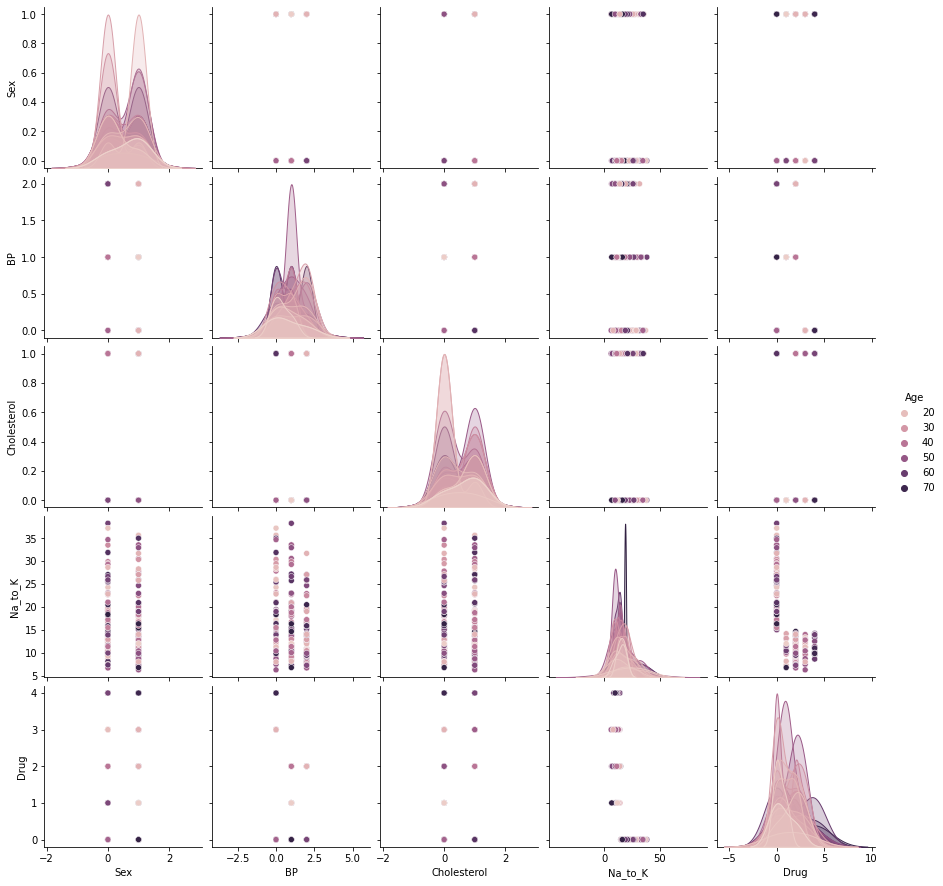

In [ ]:
sns.pairplot(DB, vars = DB.columns[1:6], hue = DB.columns[0])

## Preparación de los datos

### Analizamos los datos de forma elemental.

Calculamos la cantidad de Atributos e Instancias.

In [ ]:
NoAtributos = len(DB.T)
NoInstancias = len(DB)

Convertimos la base de datos en un arreglo.

In [ ]:
DBar = DB.to_numpy()

Calculamos el máximo y mínimo de cada Atributo.

In [ ]:
MaximoDeAtributos = []
MinimoDeAtributos = []
for idx in range(NoAtributos):
  CaractMax = max(DBar.T[idx])
  CaractMin = min(DBar.T[idx])
  MaximoDeAtributos.append(CaractMax)
  MinimoDeAtributos.append(CaractMin)

Calculamos el primer y tercer cuartil (Q1 y Q3, respectivamente), de cada atributo.

In [ ]:
Q1 = []
Q3 = []
for idx in range(NoAtributos):
  if str(type(DBar[0][idx]))[8 : -2] != 'str':
    atrib = DBar.T[idx].tolist()
    atrib.sort()

    NoCuartil1 = 0.25 * (NoInstancias + 1)
    if str(type(NoCuartil1))[8 : -2] != 'int':
      pos1 = round(NoCuartil1)
      if pos1 < NoCuartil1:
        pos2 = pos1 + 1
      else:
        pos2 = pos1 - 1
      NoCuartil1 = round((pos1 + pos2) / 2)
    Cuartil1 = atrib[NoCuartil1 + 1]
    incremento = 1
    while True:
      if str(Cuartil1) == 'nan':
          Cuartil1 = atrib[NoCuartil1]
          NoCuartil1 -= 1
      else:
        break

    NoCuartil3 = 0.7 * (NoInstancias + 1)
    if str(type(NoCuartil3))[8 : -2] != 'int':
      pos1 = round(NoCuartil3)
      if pos1 < NoCuartil3:
        pos2 = pos1 + 1
      else:
        pos2 = pos1 - 1
      NoCuartil3 = round((pos1 + pos2) / 2)
    Cuartil3 = atrib[NoCuartil3 + 1]
    while True:
      if str(Cuartil3) == 'nan':
          Cuartil3 = atrib[NoCuartil3]
          NoCuartil3 -= 1
      else:
        break

  Q1.append(Cuartil1)
  Q3.append(Cuartil3)
Q1 = np.array(Q1)
Q3 = np.array(Q3)

### Detectamos outliers y eliminamos sus respectivas instancias.

Calculamos el rango intercuantílico de cada atributo.

In [ ]:
IQR = []
for idx in range(len(Q1)):
  IQR.append(Q3[idx] - Q1[idx])

Buscamos valores atípicos y el atributo en el que se encuentra ese valor (Seleccionamos quitar solo outliers extremos con OutType = 3, o también leves con OutType = 1.5). 

In [ ]:
OutType = 3

Inst2Elim = []
for idx, Atrib in enumerate(DBar.T):
  probe1 = Q1[idx] - OutType * IQR[idx]
  probe2 = Q3[idx] + OutType * IQR[idx]
  for idx2, Val in enumerate(Atrib):
    if ((Val < probe1) or (Val > probe2)) and (idx2 not in Inst2Elim):
      Inst2Elim.append(idx2)

Generamos una nuevo array de datos eliminando las instancias que contienen algún outlier.

In [ ]:
DBWO = []
for InstNum in range(len(DBar)):
  if InstNum not in Inst2Elim:
    DBWO.append(DBar[InstNum])

DBWOar = np.array(DBWO)

Desplegamos los valores sin outliers, los cuales fueron identificados considerando el rango intercuartílico.

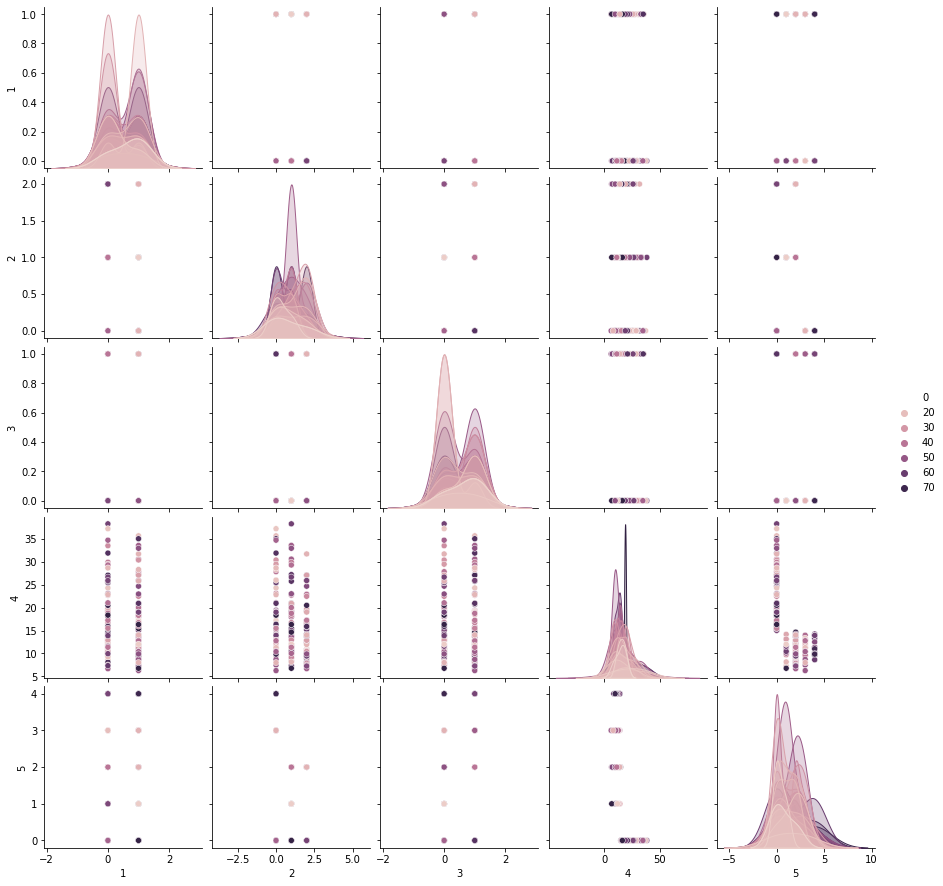

In [ ]:
showDB = pd.DataFrame(DBWOar)
sns.pairplot(showDB, vars = showDB.columns[1:6], hue = showDB.columns[0])

### Normalizamos los datos

Elegimos un rango de normalización entre 0 y 1.

In [ ]:
MaximoNormalizado = 1
MinimoNormalizado = 0
RangoNormalizado = MaximoNormalizado - MinimoNormalizado

Normalizamos los valores y obtenemos el nuevo arreglo de valores normalizados 'DBNar'.

In [ ]:
DBNorm = []
for idx in range(NoAtributos):
  
  CaractNorm = []
  if str(type(DBWOar[0][idx]))[8 : -2] != 'str':
    
    RangodeDatos = MaximoDeAtributos[idx] - MinimoDeAtributos[idx]
    for idx2 in range(NoInstancias):

      if str(DBWOar[idx2][idx]) != 'nan':
        D = DBWOar[idx2][idx] - MinimoDeAtributos[idx]
        DPct = D / RangodeDatos
        dNorm = RangoNormalizado * DPct
        Normalizado = MinimoNormalizado + dNorm
        CaractNorm.append(Normalizado)
      else:
        CaractNorm.append(DBWOar[idx2][idx])
  
  else:
    for idx2 in range(NoInstancias):
      CaractNorm.append(DBWOar[idx2][idx])
  
  DBNorm.append(CaractNorm)

DBNar = np.array(DBNorm)

Visualizamos una parte de la base de datos con los valores normalizados, para garantizar una correcta transformación.

In [ ]:
DBNarT = DBNar.T
showDB = pd.DataFrame(DBNarT)
showDB.head()

,0,1,2,3,4,5
0,0.135593,0.0,0.0,0.0,0.596848,0.00
1,0.542373,1.0,0.5,0.0,0.213397,0.25
2,0.542373,1.0,0.5,0.0,0.120239,0.25
3,0.220339,0.0,1.0,0.0,0.047814,0.50
4,0.779661,0.0,0.5,0.0,0.368191,0.00


## Análisis de los datos

### Serie de funciones creadas para obtener las métricas de rendimiento de un modelo.

In [ ]:
#Función para obtener el error cuadrático medio, recibe las listas de los valores predichos y los valores reales.
def MSE(MSEpred, MSEreal):
  MSEpredN = []
  for MSEp in MSEpred:
    MSEpredN.append(MSEp/100)

  MSErealN = []
  for MSEr in MSEreal:
    MSErealN.append(MSEr/100)
  
  MSEsize = len(MSErealN)
  MSEt = 0
  for MSEidx in range(MSEsize):
    MSEt += (MSEpredN[MSEidx] - MSErealN[MSEidx])**2
  MSEf = MSEt / MSEsize
  return(MSEf)

#Función para calcular la tasa de clasificación, recibe las listas de los valores predichos y los valores reales.
def TC(TCpred, TCreal):
  TCsize = len(TCpred)
  TCt = 0
  for TCidx in range(TCsize):
    if TCpred[TCidx] != TCreal[TCidx]:
      TCt += 1
  TCf = 1 - TCt / TCsize
  return(TCf)

#Función que obtiene los valores de la matriz de confusión (TP, FN, FP, TN), recibe las listas de los valores predichos y los valores reales.
def calculo_error(confusion_matrix):
  FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
  FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
  TP = np.diag(confusion_matrix)
  TN = confusion_matrix.sum() - (FP + FN + TP)

  FP = min(FP)
  FN = min(FN)
  TP = min(TP)
  TN = min(TN)
  return (TP, FN, FP, TN)

#Funciones para calcular la tasa de clasificación (TdC), incluyendo la exactitud (TdCExact), precisión (TdCPre), sensitividad o Recall (TdCSens)
#y puntaje F - beta con beta = 1, es decir, F1 (TdCF1).
def TdC(TdCTP, TdCFN, TdCFP, TdCTN):
  TdCExact = (TdCTP + TdCTN) / (TdCTP + TdCTN + TdCFP + TdCFN)
  TdCPre = TdCTP / (TdCTP + TdCFP)
  TdCSens = TdCTP / (TdCTP + TdCFN)
  TdCF1 = (2 * TdCTP) / (2 * TdCTP + TdCFP + TdCFN)
  return([TdCExact, TdCPre, TdCSens, TdCF1])

#Función para obtener las estadísticas de rendimiento, recibe las listas de los valores predichos y los valores reales.
def Estadisticas(EYPred, EYreal):
  EMSE = MSE(EYPred, EYreal)
  ETC = TC(EYPred, EYreal)
  CM = confusion_matrix(EYPred, EYreal)
  ETP, EFN, EFP, ETN = calculo_error(CM)
  EExact, EPrecis, ESens, EF1 = TdC(ETP, EFN, EFP, ETN)
  Estadistica = [EMSE, ETC, EExact, EPrecis, ESens, EF1]
  return(Estadistica)

### Creación de una clase propia, la cual fungirá como un árbol de decisión usando el algoritmo de ID3.

class DecisionTree_ID3():
  def Entropia(self, YE):
    YE = list(YE)
    TotalE = len(YE)
    TiposE = np.unique(YE)
    ET = 0
    for TipoE in TiposE:
      PEi = YE.count(TipoE) / TotalE
      ET -= PEi * mt.log2(PEi)
    return(ET)

  def Ganancia(self, EG, AtributoG, YG):
    AtributoGarr = AtributoG
    AtributoG = list(AtributoG)
    TotalG = len(AtributoG)
    TiposG = np.unique(AtributoG)
    GT = EG
    for TipoG in TiposG:
      posG = np.where(AtributoGarr == TipoG)[0]
      posG = np.unique(posG)
      YGSel = []
      for pG in posG:
        YGSel.append(YG[pG])
      PGi = AtributoG.count(TipoG) / TotalG
      GT -= PGi * self.Entropia(YGSel)
    return(GT)

  def PRN(self, XRN, YRN):
    SRN = self.Entropia(YRN)
    GananciasRN = []
    XRN = np.array(XRN)
    for AtributoRN in XRN.T:
      GananciasRN.append(self.Ganancia(SRN, AtributoRN, YRN))
    Rmax = max(GananciasRN)
    GananciasRN = np.array(GananciasRN)
    PosR = np.where(GananciasRN == Rmax)[0][0]
    return(PosR)

  def FDataNRes(self, XFDNR, YFDNR, RootPosFDNR, RootFDNR, LeafsFDNR):#, YGFR):
    XFDNRarr = np.array(XFDNR)
    XnewFDNR =  []
    for idxFDNR, AtribFDNR in enumerate(XFDNRarr.T):
      if idxFDNR != RootPosFDNR:
        AtribFDNR = list(AtribFDNR)
        XnewFDNR.append(AtribFDNR)
    XnewFDNR = np.array(XnewFDNR).T
    XnewFDNR = XnewFDNR.tolist()

    XOutFDNR = []
    YOutFDNR = []
    for LeafFDNR in LeafsFDNR:
      PosLeaf = np.where(RootFDNR == LeafFDNR)[0]
      X2Add = []
      Y2Add = []
      for idxFDNR in PosLeaf:
        X2Add.append(XnewFDNR[idxFDNR])
        Y2Add.append(YFDNR[idxFDNR])
      XOutFDNR.append(X2Add)
      YOutFDNR.append(Y2Add)

    LeafResFDNR = []
    LeafStatusFDNR = []
    for YLeafFDNR in YOutFDNR:
      CounterFDNR = Counter(YLeafFDNR)
      FirstFR  = CounterFDNR.most_common(1)
      LeafResFDNR.append(FirstFR[0][0])

      if len(np.unique(YLeafFDNR)) == 1:
        LeafStatusFDNR.append(1)
      else:
        LeafStatusFDNR.append(0)
    return(XOutFDNR, YOutFDNR, LeafResFDNR, LeafStatusFDNR)

  def FindRoot(self, XFR, YFR):
    RootPosFR = self.PRN(XFR, YFR)
    XFRarr = np.array(XFR)
    Root = XFRarr.T[RootPosFR]
    LeafsFR = np.unique(Root)
    DataNRes = self.FDataNRes(XFR, YFR, RootPosFR, Root, LeafsFR)#, YGFR)
    Data4LeafXFR = DataNRes[0]
    Data4LeafYFR = DataNRes[1]
    LeafsResultsFR = DataNRes[2]
    LeafsStatusFR = DataNRes[3]
    return(RootPosFR, LeafsFR, Data4LeafXFR, Data4LeafYFR, LeafsResultsFR, LeafsStatusFR)

  def PredDato(XPD, DTPD):
    ProfundidadPD = 0
    NumLeadPD = 0
    RootPD = XPD[DTPD[0][ProfundidadPD][NumLeadPD]]
    LeafsPD = DTPD[1][ProfundidadPD][NumLeadPD]
    NextPosPD = np.where(LeafsPD == RootPD)[0][0]
    Ypred = DTPD[2][ProfundidadPD][NumLeadPD][NextPosPD]
    while (DTPD[5][ProfundidadPD][NumLeadPD][NextPosPD] != 1):
      try:
        ProfundidadPD += 1
        NumLeadPD = NextPosPD
        RootPD = XPD[DTPD[0][ProfundidadPD][NumLeadPD]]
        LeafsPD = DTPD[1][ProfundidadPD][NumLeadPD]
        NextPosPD = np.where(LeafsPD == RootPD)[0][0]
        Ypred = DTPD[2][ProfundidadPD][NumLeadPD][NextPosPD]
      except:
        break
    return(Ypred)

  def fit(self, Xtrainfit, Ytrainfit):
    AtribQuantity = len(Xtrainfit.T)
    RootRes = self.FindRoot(Xtrainfit, Ytrainfit)
    RootPos = RootRes[0]
    Leafs = RootRes[1]
    Data4LeafX = RootRes[2]
    Data4LeafY = RootRes[3]
    LeafsResults = RootRes[4]
    LeafsStatus = RootRes[5]
    print(RootPos)
    print(Leafs)
    print(Data4LeafX)
    print(Data4LeafY)
    print(LeafsResults)
    print(LeafsStatus)
    FinalStatus = len(np.unique(LeafsStatus))
    UsedAtrib = 1
    self.Profundidad = 0
    self.DT = [[[RootPos]], [Leafs], [Data4LeafX], [Data4LeafY], [LeafsResults], [LeafsStatus]]
    while (UsedAtrib != AtribQuantity) or (FinalStatus != 1):
      self.Profundidad += 1
      for Root in self.DT[0][self.Profundidad-1]:
        self.DT[0].append([])
        #self.DT[1].append([])
        #self.DT[2].append([])
        #self.DT[3].append([])
        #self.DT[4].append([])
        #self.DT[5].append([])
        for idx, DataX in enumerate(self.DT[2][self.Profundidad-1]):
          Xtemp = DataX
          Ytemp = self.DT[3][self.Profundidad-1][idx]
          if self.DT[5][self.Profundidad-1][idx] != 1: 
            RootRes = self.FindRoot(Xtemp, Ytemp)
            RootPos = RootRes[0]
            Leafs = RootRes[1]
            Data4LeafX = RootRes[2]
            Data4LeafY = RootRes[3]
            LeafsResults = RootRes[4]
            LeafsStatus = RootRes[5]
            #self.DT[0][self.Profundidad].append(RootPos)
            #self.DT[1][self.Profundidad].append(Leafs)
            #self.DT[2][self.Profundidad].append(LeafsResults)
            #self.DT[3][self.Profundidad].append(Data4LeafX)
            #self.DT[4][self.Profundidad].append(Data4LeafY)
            #self.DT[5][self.Profundidad].append(LeafsStatus)
            self.DT[0][self.Profundidad].append(RootPos)
            self.DT[1].append(Leafs)
            self.DT[2].append(LeafsResults)
            self.DT[3].append(Data4LeafX)
            self.DT[4].append(Data4LeafY)
            self.DT[5].append(LeafsStatus)
            UsedAtrib += 1
      lf = []      
      for element in self.DT[5][self.Profundidad]:
        lf.append(len(np.unique(element)))
      FinalStatus = len(np.unique(lf))

    def GetPred(self, Datos):
      Ypred = []
      for data in Datos:
        Ypred.append(self.PredDatos(data, self.DT))
      return(Ypred)

In [ ]:
class DecisionTree_ID3():
  def Entropia(self, YE):
    YE = list(YE)
    TotalE = len(YE)
    TiposE = np.unique(YE)
    ET = 0
    for TipoE in TiposE:
      PEi = YE.count(TipoE) / TotalE
      ET -= PEi * mt.log2(PEi)
    return(ET)

  def Ganancia(self, EG, AtributoG, YG):
    AtributoGarr = AtributoG
    AtributoG = list(AtributoG)
    TotalG = len(AtributoG)
    TiposG = np.unique(AtributoG)
    GT = EG
    for TipoG in TiposG:
      posG = np.where(AtributoGarr == TipoG)[0]
      posG = np.unique(posG)
      YGSel = []
      for pG in posG:
        YGSel.append(YG[pG])
      PGi = AtributoG.count(TipoG) / TotalG
      GT -= PGi * self.Entropia(YGSel)
    return(GT)

  def PRN(self, XRN, YRN):
    SRN = self.Entropia(YRN)
    GananciasRN = []
    XRN = np.array(XRN)
    for AtributoRN in XRN.T:
      GananciasRN.append(self.Ganancia(SRN, AtributoRN, YRN))
    Rmax = max(GananciasRN)
    GananciasRN = np.array(GananciasRN)
    PosR = np.where(GananciasRN == Rmax)[0][0]
    return(PosR)

  def FDataNRes(self, XFDNR, YFDNR, RootPosFDNR, RootFDNR, LeafsFDNR):#, YGFR):
    XFDNRarr = np.array(XFDNR)
    XnewFDNR =  []
    for idxFDNR, AtribFDNR in enumerate(XFDNRarr.T):
      if idxFDNR != RootPosFDNR:
        AtribFDNR = list(AtribFDNR)
        XnewFDNR.append(AtribFDNR)
    XnewFDNR = np.array(XnewFDNR).T
    XnewFDNR = XnewFDNR.tolist()

    XOutFDNR = []
    YOutFDNR = []
    if len(XnewFDNR) != 0:
      for LeafFDNR in LeafsFDNR:
        PosLeaf = np.where(RootFDNR == LeafFDNR)[0]
        X2Add = []
        Y2Add = []
        for idxFDNR in PosLeaf:
          X2Add.append(XnewFDNR[idxFDNR])
          Y2Add.append(YFDNR[idxFDNR])
        XOutFDNR.append(X2Add)
        YOutFDNR.append(Y2Add)

    LeafResFDNR = []
    LeafStatusFDNR = []
    for YLeafFDNR in YOutFDNR:
      CounterFDNR = Counter(YLeafFDNR)
      FirstFR  = CounterFDNR.most_common(1)
      LeafResFDNR.append(FirstFR[0][0])

      if len(np.unique(YLeafFDNR)) == 1:
        LeafStatusFDNR.append(1)
      else:
        LeafStatusFDNR.append(0)
    return(XOutFDNR, YOutFDNR, LeafResFDNR, LeafStatusFDNR)

  def FindRoot(self, XFR, YFR):
    RootPosFR = self.PRN(XFR, YFR)
    XFRarr = np.array(XFR)
    Root = XFRarr.T[RootPosFR]
    LeafsFR = np.unique(Root)
    DataNRes = self.FDataNRes(XFR, YFR, RootPosFR, Root, LeafsFR)#, YGFR)
    Data4LeafXFR = DataNRes[0]
    Data4LeafYFR = DataNRes[1]
    LeafsResultsFR = DataNRes[2]
    LeafsStatusFR = DataNRes[3]
    return(RootPosFR, LeafsFR, Data4LeafXFR, Data4LeafYFR, LeafsResultsFR, LeafsStatusFR)

  def PredDato(self, XPD, DTPD):
    ProfundidadPD = 0
    RootPD = XPD[DTPD[0][ProfundidadPD][0]]
    LeafsPD = DTPD[1][ProfundidadPD]
    NextPosPD = np.where(LeafsPD == RootPD)[0][0]
    Ypred = DTPD[4][ProfundidadPD][NextPosPD]
    while (DTPD[5][ProfundidadPD][NextPosPD] != 1):
      try:
        ProfundidadPD += 1
        RootPD = XPD[DTPD[0][ProfundidadPD][NextPosPD]]
        LeafsPD = DTPD[1][ProfundidadPD][NextPosPD]
        NextPosPD = np.where(LeafsPD == RootPD)[0][0]
        Ypred = DTPD[4][ProfundidadPD][NextPosPD]
      except:
        break
    return(Ypred)

  def fit(self, Xtrainfit, Ytrainfit):
    AtribQuantity = len(Xtrainfit.T)
    RootRes = self.FindRoot(Xtrainfit, Ytrainfit)
    RootPos = RootRes[0]
    Leafs = RootRes[1]
    Data4LeafX = RootRes[2]
    Data4LeafY = RootRes[3]
    LeafsResults = RootRes[4]
    LeafsStatus = RootRes[5]
    FinalStatus = len(np.unique(LeafsStatus))
    UsedAtrib = 1
    self.Profundidad = 0
    self.DT = [[[RootPos]], [Leafs], [Data4LeafX], [Data4LeafY], [LeafsResults], [LeafsStatus]]
    while (UsedAtrib != AtribQuantity) and (FinalStatus != 1):
      self.Profundidad += 1
      self.DT[0].append([])
      for idx, Root in enumerate(self.DT[1][self.Profundidad-1]):
        Xtemp = self.DT[2][self.Profundidad-1][idx]
        Ytemp = self.DT[3][self.Profundidad-1][idx]
        if self.DT[5][self.Profundidad-1][idx] != 1: 
          RootRes = self.FindRoot(Xtemp, Ytemp)
          RootPos = RootRes[0]
          Leafs = RootRes[1]
          Data4LeafX = RootRes[2]
          Data4LeafY = RootRes[3]
          LeafsResults = RootRes[4]
          LeafsStatus = RootRes[5]
          self.DT[0][self.Profundidad].append(RootPos)
          self.DT[1].append(Leafs)
          self.DT[2].append(Data4LeafX)
          self.DT[3].append(Data4LeafY)
          self.DT[4].append(LeafsResults)
          self.DT[5].append(LeafsStatus)
          UsedAtrib += 1
      FinalStatus = len(np.unique(self.DT[5][self.Profundidad]))

  def GetPred(self, Datos):
    Ypred = []
    for data in Datos:
      Ypred.append(self.PredDato(data, self.DT))
    return(Ypred)

## Entrenamos un modelo con el algoritmo de KNN generado.

### Generación de X e Y

Agregamos aleatoriedad al orden de la base de datos.

In [ ]:
RDBNar = rd.sample(DBNar.T.tolist(), k=len(DBNar.T))
RDBNar = np.array(RDBNar).T

Seleccionamos el atributo para nuestro valor objetivo 'Y' y el resto 'X' como ejemplos para el entrenamiento.

In [ ]:
X = DBNar[1:-2]
X = X.T
Y = DBNar[-1]

### Entrenamos el modelo

Haremos 5 pruebas, eligiendo K=5 para el método de K-FOLD, en este caso, 5-FOLD.

La base de datos ya se encuentra ordenada aletaoriamente, por lo tanto solo tomaremos distintas secciones para el 20% de pruebas y su respectivo 80% para netrenamiento.

In [ ]:
Xres = X
Yres = Y

DBsize = len(Xres)
DBp = DBsize / 5
VDB = int(DBp)
CDB = int(DBp * 2)
SDB = int(DBp * 3)
ODB = int(DBp * 4)

Xtest1, Xtrain1, Ytest1, Ytrain1 = train_test_split(Xres, Yres, test_size = 0.80, shuffle = False)

Xtrain2, Ytrain2 = Xres[:VDB].tolist() + Xres[CDB:].tolist(), Yres[:VDB].tolist() + Yres[CDB:].tolist()
Xtrain2, Ytrain2 = np.array(Xtrain2), np.array(Ytrain2)
Xtest2, Ytest2 = Xres[VDB:CDB], Yres[VDB:CDB]

Xtrain3, Ytrain3 = Xres[:CDB].tolist() + Xres[SDB:].tolist(), Yres[:CDB].tolist() + Yres[SDB:].tolist()
Xtrain3, Ytrain3 = np.array(Xtrain3), np.array(Ytrain3)
Xtest3, Ytest3 = Xres[CDB:SDB], Yres[CDB:SDB]

Xtrain4, Ytrain4 = Xres[:SDB].tolist() + Xres[ODB:].tolist(), Yres[:SDB].tolist() + Yres[ODB:].tolist()
Xtrain4, Ytrain4 = np.array(Xtrain4), np.array(Ytrain4)
Xtest4, Ytest4 = Xres[SDB:ODB], Yres[SDB:ODB]

Xtrain5, Xtest5, Ytrain5, Ytest5 = train_test_split(Xres, Yres, test_size = 0.20, shuffle = False)

Entrenamos con KNN cada uno de los 5 grupos de datos
Nota: Es posible elegir qué métrica ('MSE', 'TdC', 'Exactitud', 'Precision', 'Recall' o 'F1') tomar como referencia, en este caso se elige 'Precision'.

In [ ]:
model1 = DecisionTree_ID3()
model1.fit(Xtrain1, Ytrain1)

model2 = DecisionTree_ID3()
model2.fit(Xtrain2, Ytrain2)

model3 = DecisionTree_ID3()
model3.fit(Xtrain3, Ytrain3)

model4 = DecisionTree_ID3()
model4.fit(Xtrain4, Ytrain4)

model5 = DecisionTree_ID3()
model5.fit(Xtrain5, Ytrain5)

Determinamos las predicciones de cada modelo.

In [ ]:
Ymodel1Pred = model1.GetPred(Xtest1)
TasCla1 = TC(Ymodel1Pred, Ytest1)

Ymodel2Pred = model2.GetPred(Xtest2)
TasCla2 = TC(Ymodel2Pred, Ytest2)

Ymodel3Pred = model3.GetPred(Xtest3)
TasCla3 = TC(Ymodel3Pred, Ytest3)

Ymodel4Pred = model4.GetPred(Xtest4)
TasCla4 = TC(Ymodel4Pred, Ytest4)

Ymodel5Pred = model5.GetPred(Xtest5)
TasCla5 = TC(Ymodel5Pred, Ytest5)

StadisticFin = (TasCla1 + TasCla2 + TasCla3 + TasCla4 + TasCla5) / 5

In [ ]:
print('Tasa de clasificación de la prueba 1 =', str(TasCla1) + '.')
print('Tasa de clasificación de la prueba 2 =', str(TasCla2) + '.')
print('Tasa de clasificación de la prueba 3 =', str(TasCla3) + '.')
print('Tasa de clasificación de la prueba 4 =', str(TasCla4) + '.')
print('Tasa de clasificación de la prueba 5 =', str(TasCla5) + '.')
print('Precisión final =', str(StadisticFin) + '.')

Tasa de clasificación de la prueba 1 = 0.65.
Tasa de clasificación de la prueba 2 = 0.475.
Tasa de clasificación de la prueba 3 = 0.55.
Tasa de clasificación de la prueba 4 = 0.375.
Tasa de clasificación de la prueba 5 = 0.55.
Precisión final = 0.5199999999999999.


## Evaluamos el modelo

### Analizamos métricas de evaluación

Tranformamos los datos de las etiquetas a enteros.

In [ ]:
Yt1 = []
for Ytt1 in Ytest1:
  Yt1.append(int(Ytt1*100))

Ytp1 = []
for Yttp1 in Ymodel1Pred:
  Ytp1.append(int(Yttp1*100))

Ytp2 = []
for Yttp2 in Ymodel2Pred:
  Ytp2.append(int(Yttp2*100))

Ytp3 = []
for Yttp3 in Ymodel3Pred:
  Ytp3.append(int(Yttp3*100))

Ytp4 = []
for Yttp4 in Ymodel4Pred:
  Ytp4.append(int(Yttp4*100))

Ytp5 = []
for Yttp5 in Ymodel5Pred:
  Ytp5.append(int(Yttp5*100))

print(Yt1)
print(Ytp1)

[0, 25, 25, 50, 0, 50, 0, 25, 0, 0, 25, 0, 0, 0, 50, 0, 50, 75, 25, 0, 0, 0, 0, 0, 0, 0, 0, 50, 0, 0, 50, 100, 50, 0, 50, 50, 75, 50, 50, 50]
[0, 0, 0, 50, 0, 50, 50, 0, 50, 0, 0, 0, 0, 0, 50, 0, 0, 0, 0, 0, 0, 50, 0, 0, 0, 0, 0, 50, 0, 0, 50, 0, 0, 0, 50, 50, 0, 0, 50, 50]


Generamos la tabla de métricas.

In [ ]:
from tabulate import tabulate

ModelStatistics = Estadisticas(Ytp1, Yt1)

STable = [ ['MSE', str(ModelStatistics[0])],
     ['Tasa de clasificación', str(ModelStatistics[1])],
     ['Exactitud', str(ModelStatistics[2])],
     ['Precisión', str(ModelStatistics[3])],
     ['Recall', str(ModelStatistics[4])],
     ['F1', str(ModelStatistics[5])] ]

print(tabulate(STable, headers = ['Métrica modelo 1', 'Valor'], tablefmt="presto"))

ModelStatistics = Estadisticas(Ytp2, Yt1)

STable = [ ['MSE', str(ModelStatistics[0])],
     ['Tasa de clasificación', str(ModelStatistics[1])],
     ['Exactitud', str(ModelStatistics[2])],
     ['Precisión', str(ModelStatistics[3])],
     ['Recall', str(ModelStatistics[4])],
     ['F1', str(ModelStatistics[5])] ]

print(tabulate(STable, headers = ['Métrica modelo 2', 'Valor'], tablefmt="presto"))

ModelStatistics = Estadisticas(Ytp3, Yt1)

STable = [ ['MSE', str(ModelStatistics[0])],
     ['Tasa de clasificación', str(ModelStatistics[1])],
     ['Exactitud', str(ModelStatistics[2])],
     ['Precisión', str(ModelStatistics[3])],
     ['Recall', str(ModelStatistics[4])],
     ['F1', str(ModelStatistics[5])] ]

print(tabulate(STable, headers = ['Métrica modelo 3', 'Valor'], tablefmt="presto"))

ModelStatistics = Estadisticas(Ytp4, Yt1)

STable = [ ['MSE', str(ModelStatistics[0])],
     ['Tasa de clasificación', str(ModelStatistics[1])],
     ['Exactitud', str(ModelStatistics[2])],
     ['Precisión', str(ModelStatistics[3])],
     ['Recall', str(ModelStatistics[4])],
     ['F1', str(ModelStatistics[5])] ]

print(tabulate(STable, headers = ['Métrica modelo 4', 'Valor'], tablefmt="presto"))

ModelStatistics = Estadisticas(Ytp5, Yt1)

STable = [ ['MSE', str(ModelStatistics[0])],
     ['Tasa de clasificación', str(ModelStatistics[1])],
     ['Exactitud', str(ModelStatistics[2])],
     ['Precisión', str(ModelStatistics[3])],
     ['Recall', str(ModelStatistics[4])],
     ['F1', str(ModelStatistics[5])] ]

print(tabulate(STable, headers = ['Métrica modelo 5', 'Valor'], tablefmt="presto"))

 Métrica modelo 1      |       Valor
-----------------------+-------------
 MSE                   |   0.0984375
 Tasa de clasificación |   0.65
 Exactitud             |   0.9
 Precisión             |   0
 Recall                | nan
 F1                    |   0
 Métrica modelo 2      |      Valor
-----------------------+------------
 MSE                   |   0.135937
 Tasa de clasificación |   0.425
 Exactitud             |   0.875
 Precisión             |   0
 Recall                | nan
 F1                    |   0
 Métrica modelo 3      |      Valor
-----------------------+------------
 MSE                   |   0.123438
 Tasa de clasificación |   0.425
 Exactitud             |   0.857143
 Precisión             |   0
 Recall                | nan
 F1                    |   0
 Métrica modelo 4      |      Valor
-----------------------+------------
 MSE                   |   0.154688
 Tasa de clasificación |   0.425
 Exactitud             |   0.833333
 Precisión             |   0
 Rec

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in long_scalars


Obtenemos la matriz de confusión de los datos de validación.

Matriz de confusión de la prueba 1



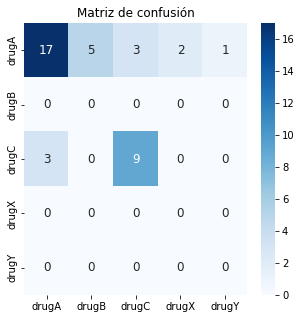



Matriz de confusión de la prueba 2



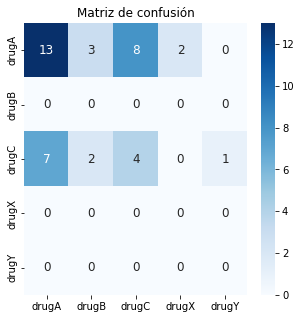



Matriz de confusión de la prueba 3



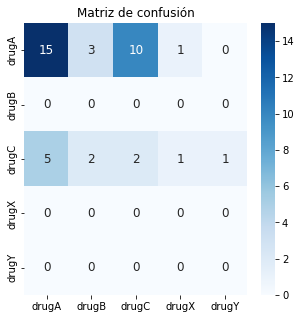



Matriz de confusión de la prueba 4



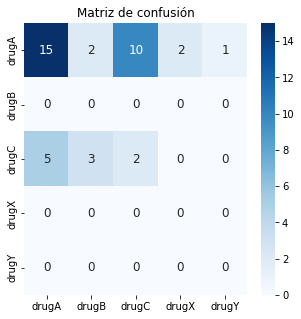



Matriz de confusión de la prueba 5



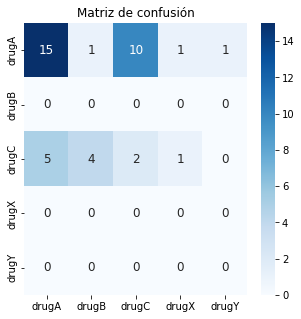

In [ ]:
def confusionMatrix(y_data_test, y_pred_test, titleChart, columns):
  cm = confusion_matrix(y_data_test, y_pred_test)
  cm=pd.DataFrame(cm, index=columns, columns=columns)
  plt.figure(figsize = (5,5))
  plt.title(titleChart)
  sns.heatmap(cm, annot = True,fmt="d", cmap='Blues' ,annot_kws={"size": 12})
  plt.show()

print('Matriz de confusión de la prueba 1\n')
confusionMatrix(Ytp1, Yt1, 'Matriz de confusión', list(np.unique(DB_STAY['Drug'])))
print('\n\nMatriz de confusión de la prueba 2\n')
confusionMatrix(Ytp2, Yt1, 'Matriz de confusión', list(np.unique(DB_STAY['Drug'])))
print('\n\nMatriz de confusión de la prueba 3\n')
confusionMatrix(Ytp3, Yt1, 'Matriz de confusión', list(np.unique(DB_STAY['Drug'])))
print('\n\nMatriz de confusión de la prueba 4\n')
confusionMatrix(Ytp4, Yt1, 'Matriz de confusión', list(np.unique(DB_STAY['Drug'])))
print('\n\nMatriz de confusión de la prueba 5\n')
confusionMatrix(Ytp5, Yt1, 'Matriz de confusión', list(np.unique(DB_STAY['Drug'])))

Finalmente, usaremos el intervalo de confianza Z para obtener los valores entre los que se encontraría la tasa de clasificación global.

In [ ]:
def media(Nums):
  n = len(Nums)
  Suma = 0
  for Num in Nums:
    Suma += Num
  ResM = Suma/n
  return(ResM)

def DesvEst(Nums):
  n = len(Nums)
  med = media(Nums)
  Suma = 0
  for Num in Nums:
    Suma += (Num - med)**2
  ResDE = (Suma / n)**0.5
  return(ResDE)

Cant_Pruebas = 50
TCs = []
for n in range(Cant_Pruebas):
  model = DecisionTree_ID3()
  model.fit(Xtrain1, Ytrain1)
  YmodelPred = model.GetPred(Xtest1)
  TasCla = TC(YmodelPred, Ytest1)
  TCs.append(TasCla)

MediaTC = media(TCs)
DesvEstTC = DesvEst(TCs)

Z = 1.96

RangoError = Z*(DesvEstTC/(Cant_Pruebas)**0.5)

print('Elegimos un valor de Z = 1.96 para un intervalo de confianza de 95%, logrando así un valor global de tasa de clasifciacion =', str(round(MediaTC, 4)), ' y un intervalo de confianza de', str(RangoError) + '.')
print('\nLo anterior quiere decir, que el valor real de Tasa de clasificación está entre', str(MediaTC - RangoError), 'y', str(MediaTC + RangoError) + '.')

Elegimos un valor de Z = 1.96 para un intervalo de confianza de 95%, logrando así un valor global de tasa de clasifciacion = 0.65  y un intervalo de confianza de 1.5386906095100993e-16.

Lo anterior quiere decir, que el valor real de Tasa de clasificación está entre 0.6499999999999994 y 0.6499999999999996.
